In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
%matplotlib inline
import Bio

In [3]:
print("Biopython v" + Bio.__version__)

Biopython v1.76


## First look at sequences

In [7]:
from Bio.Seq import Seq
sequence = Seq("AAGTTAGATCGATTACACTAGT")
print(sequence)


AAGTTAGATCGATTACACTAGT


In [11]:
seqalph = sequence.alphabet

In [12]:
seqalph.letters,seqalph.size 

(None, None)

In [13]:
print('{} | Sequence '.format(sequence))
print('{} | Complement '.format(sequence.complement()))
print('{} | Reverse complement '.format(sequence.reverse_complement()))

AAGTTAGATCGATTACACTAGT | Sequence 
TTCAATCTAGCTAATGTGATCA | Complement 
ACTAGTGTAATCGATCTAACTT | Reverse complement 


## Dealing with file formats

In [15]:
from Bio import SeqIO
count = 0
sequences = [] 
folder = "drosophila-melanogaster-genome/"
for seq_record in SeqIO.parse(folder+"genome.fa", "fasta"):
    if (count < 3):
        sequences.append(seq_record)
        print("Id: " + seq_record.id + " \t " + "Length: " + str("{:,d}".format(len(seq_record))) )
        print(repr(seq_record.seq) + "\n")
        count = count + 1

Id: chr2L 	 Length: 23,513,712
Seq('Cgacaatgcacgacagaggaagcagaacagatatttagattgcctctcattttc...gag', SingleLetterAlphabet())

Id: chr2R 	 Length: 25,286,936
Seq('CTCAAGATAccttctacagattatttaaagctagtgcacaacaacaataaattg...ttc', SingleLetterAlphabet())

Id: chr3L 	 Length: 28,110,227
Seq('TAGGGAGAAATATGATCgcgtatgcgagagtagtgccaacatattgtgctcttt...tat', SingleLetterAlphabet())



What the previous command provides the first 3 sequence in the genomic data set of the Drosophila Melanogaster (Kaggle)

In [57]:

lengths = []
for seq_record in SeqIO.parse(folder+"genome.fa", "fasta"):
    #print("Length: {:,d}".format(len(seq_record))) 
    sequences.append(seq_record)
    lengths.append(len(seq_record))

In [46]:
#genome = pd.DataFrame(np.column_stack((sequences, lengths)),
#                     columns = ['sequence', 'length'])

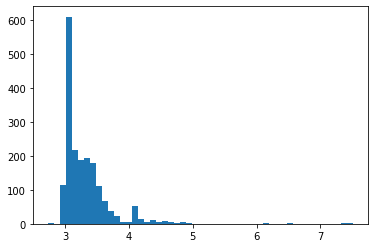

In [47]:
h = plt.hist(np.log10(lengths),51)

In [49]:
np.sum(lengths)

143726002

In [19]:
print('Lengths of the 3 first sequences are {}, {} and {}'.format(
                        *tuple(len(chrt) for chrt in sequences[:3])))

Lengths of the 3 first sequences are 23513712, 25286936 and 28110227


In [24]:
print('First characters are {}, {} and {}'.format(
                        *tuple(chrt[0] for chrt in sequences[:3])))
print('Last characters are {}, {} and {}'.format(
                        *tuple(chrt[-1] for chrt in sequences[:3])))
i = np.random.randint(1000)
print('{}-th characters are {}, {} and {}'.format(i,
                        *tuple(chrt[i] for chrt in sequences[:3])))

First characters are C, C and T
Last characters are g, c and t
476-th characters are g, c and c


In [58]:
print('Occurrences of G are {}, {} and {}'.format(
                        *tuple(chrt.seq.count("G") 
                               for chrt in sequences[:3])))
print('Occurrences of A are {}, {} and {}'.format(
                        *tuple(chrt.seq.count("A")
                               for chrt in sequences[:3])))
print('Occurrences of T are {}, {} and {}'.format(
                        *tuple(chrt.seq.count("T") 
                               for chrt in sequences[:3])))
print('Occurrences of C are {}, {} and {}'.format(
                        *tuple(chrt.seq.count("C") 
                               for chrt in sequences[:3])))

Occurrences of G are 4428980, 4260578 and 4761392
Occurrences of A are 6075234, 5579958 and 6523956
Occurrences of T are 6067775, 5560784 and 6558241
Occurrences of C are 4417944, 4265630 and 4766181


In [95]:
%%time
alphab = ['A', 'G', 'C', 'T', 'S']
oc = {ch: [] for ch in alphab}
for ch in alphab:
    oc['Total_'+ch] =  []
    
for chrt in sequences:
    for ch in alphab:
        try:
            oc[ch].append(chrt.seq.count(ch))
            oc['Total_'+ch].append(len(chrt.seq))
        except:
            try:
                oc[ch].append(chrt.count(ch))
                oc['Total_'+ch].append(len(chrt))

            except:
                pass
            
    
            

CPU times: user 3.81 s, sys: 0 ns, total: 3.81 s
Wall time: 3.81 s


In [96]:

for ch in alphab:
    oc[ch] = np.array(oc[ch])
    oc['Total_'+ch] = np.array(oc['Total_'+ch])

Text(0.5, 0, '# occurences')

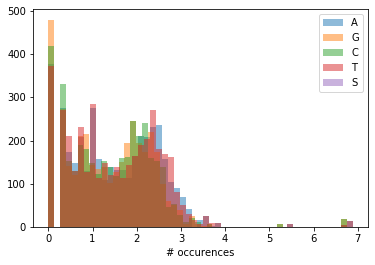

In [98]:

for ch in alphab:
    h = plt.hist(np.log10(oc[ch][oc[ch]>0]),51,alpha = 0.5, label = ch)
    
plt.legend()
plt.xlabel('# occurences')

In [32]:
def gccontent(seq): 
    return 100*(seq.count("G")+seq.count("C"))/len(seq)
    
print('GC contents are {:.2f}, {:.2f} and {:.2f}'.format(
                        *tuple(gccontent(chrt.seq) for chrt in sequences)))

GC contents are 37.62, 33.72 and 33.89


In [33]:
from Bio.SeqUtils import GC
print('GC contents are {:.2f}, {:.2f} and {:.2f}'.format(
                        *tuple(GC(chrt.seq) for chrt in sequences[:3])))

GC contents are 41.78, 42.60 and 41.44


In [100]:
gcC = []
for chrt in sequences:
    for ch in alphab:
        try:
            gcC.append(GC(chrt.seq))    
        except:
            try:
                gcC.append(GC(chrt))
            except:
                pass

Text(0.5, 0, 'GC content')

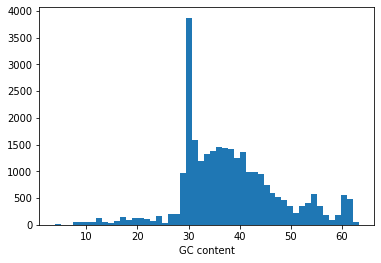

In [103]:
h = plt.hist(gcC, 51)
plt.xlabel('GC content')

The differences are in lowercase and capital letters!! Also there are S and s characters that represent an ambiguous G or C character.

## Machine Learning

First we are going to change the representation to n-gram estimators:


In [34]:
from sklearn.feature_extraction.text import CountVectorizer

def ngram_estimator(n, a_text, s_text, full_output = False):
    ''' Caculate the n-gram arrays corresponding to a_text and s_tex
    '''
    
    counter = CountVectorizer(analyzer = 'word', ngram_range = (n,n))
    
    vocabulary = counter.fit([a_text, s_text]).vocabulary_
    
    ngrams = counter.fit_transform([a_text, s_text])
    #print(vocabulary)
    if full_output:
        output = ngrams.toarray(), counter
    else:
        output = ngrams.toarray()
    
    return output

### Containment

Containment will help us determine similarity between sequences..

$$\mathrm{containment} = \frac{|N_A\cap N_S|}{|N_A|} $$



In [35]:
# Calculate the ngram containment for one answer file/source file pair in a df
def calculate_containment(seqA, seqB, n):
    '''Calculates the containment between a given answer text and its associated source text.
       This function creates a count of ngrams (of a size, n) for each text file in our data.
       Then calculates the containment by finding the ngram count for a given answer text, 
       and its associated source text, and calculating the normalized intersection of those counts.
       :param df: A dataframe with columns,
           'File', 'Task', 'Category', 'Class', 'Text', and 'Datatype'
       :param n: An integer that defines the ngram size
       :param answer_filename: A filename for an answer text in the df, ex. 'g0pB_taskd.txt'
       :return: A single containment value that represents the similarity
           between an answer text and its source text.
    '''
    
    
    ngram_array = ngram_estimator(n, seqA, seqB)
    ngram_min = ngram_array.min(axis=0)
    containment = ngram_min.sum()/ngram_array[0,:].sum()
        
    return containment

### Longest common sentence

We use dynamic programming

In [36]:
def lcs_norm_word(textA, textB):
    '''Computes the longest common subsequence of words in two texts; returns a normalized value.
       :param answer_text: The pre-processed text for an answer text
       :param source_text: The pre-processed text for an answer's associated source text
       :return: A normalized LCS value'''
    
    A_l = textA.split()
    B_l = textB.split()
    lcsmatrix = np.zeros((len(B_l)+1,len(A_l)+1))
    idx = 0
    for i, word in enumerate(B_l):
        for j, word_A in enumerate(A_l):
            if word == word_A:
                lcsmatrix[i+1,j+1] = lcsmatrix[i,j]+1.0
            else:
                lcsmatrix[i+1,j+1] = np.max([lcsmatrix[i+1,j], 
                                             lcsmatrix[i,j+1]])
                
    return lcsmatrix[-1,-1]/len(A_l)


Now we create containment features

In [113]:

def create_containment_features(sequences, n):
    
    containment_values = []
    
    # iterates through sequences
    for i, seqA in enumerate(sequences):
        for j, seqB in enumerate(sequences[i+1:]):
            c = calculate_containment(seqA, seqB, n)
            containment_values.append(c)
    
    print(str(n)+'-gram containment features created!')
    return containment_values


In [114]:
def create_lcs_features(sequences):
    
    lcs_values = []
    
    for i, seqA in enumerate(sequences):
        for j, seqB in enumerate(sequences[i+1:]):
            # calculate lcs
            lcs = lcs_norm_word(seqA, seqB)
            lcs_values.append(lcs)
            
    print('LCS features created!')
    return lcs_values

In [117]:
strseq = []
for seq in sequences:
    try:
        strseq.append(str(seq.seq))
    except:
        try:
            strseq.append(str(seq))
        except:
            pass
print(len(strseq))

5613


In [ ]:
ngram_range = range(1,10)

features_list = []

all_features = np.zeros((len(ngram_range)+1, 
                         len(sequences)*(len(sequences)-1)//2))

# Calculate features for containment for ngrams in range
i=0
for n in ngram_range:
    column_name = 'c_'+str(n)
    features_list.append(column_name)
    # create containment features
    all_features[i]=np.squeeze(create_containment_features(strseq, n))
    i+=1

# Calculate features for LCS_Norm Words 
features_list.append('lcs_word')
all_features[i]= np.squeeze(create_lcs_features(strseq))

# create a features dataframe
features_df = pd.DataFrame(np.transpose(all_features), columns=features_list)

# Print all features/columns
print()
print('Features: ', features_list)
print()